# Aim

Solve an LQR toy problem to see what to do

In [13]:
import numpy as np
from scipy import linalg as la
from scipy import stats as st
from matplotlib import pyplot as plt

inv = np.linalg.inv
mvn = st.multivariate_normal
rms = lambda data: round(np.sqrt(np.mean((data - np.mean(data)) ** 2)), 4)

In [19]:
s = 2
m = 1
p = 1
nsteps = 10000

In [34]:
A = np.array([[2, -1], [1, 0]])
B = np.random.randn(s,m)
C = np.random.randn(p,s)
Q = np.eye(s)
R = np.eye(m)
W = 0.5 * np.eye(s)
V = 10 * np.eye(p)
process_dist = mvn(cov=W)
measure_dist = mvn(cov=V)
x = process_dist.rvs()

In [27]:
kalman_cov = la.solve_discrete_are(A.T, C.T, W, V)
kalman_gain = kalman_cov @ C.T @ inv(C @ kalman_cov @ C.T + V)
lqr_cov = la.solve_discrete_are(A, B, Q, R)
lqr_gain = -inv(R + B.T @ lqr_cov @ B) @ B.T @ lqr_cov @ A

In [37]:
states_un = np.zeros((nsteps, s))
states_un[0,:] = x
for i in range(1, nsteps):
    states_un[i,:] = A @ states_un[i-1,:] + process_dist.rvs()
    
rms(states_un @ C.T)

88094.0103

In [40]:
states = np.zeros((nsteps, s))
states_hat = np.zeros((nsteps, s))
states[0,:] = x
states_hat[0,:] = x
for i in range(1, nsteps):
    x = states[i-1,:]
    x_hat = states_hat[i-1,:]
    u = -lqr_gain @ x_hat
    y = C @ (A @ x + B @ u) + measure_dist.rvs()
    innovation = y - C @ (A @ x_hat + B @ u)
    states_hat[i,:] = A @ x_hat + B @ u + kalman_gain @ innovation
    states[i,:] = states[i,:] + process_dist.rvs()
    
rms(states @ C.T)

<ipython-input-40-13e19045e37c>:8: RuntimeWarning: overflow encountered in matmul
  u = -lqr_gain @ x_hat
<ipython-input-40-13e19045e37c>:9: RuntimeWarning: invalid value encountered in matmul
  y = C @ (A @ x + B @ u) + measure_dist.rvs()
<ipython-input-40-13e19045e37c>:10: RuntimeWarning: invalid value encountered in matmul
  innovation = y - C @ (A @ x_hat + B @ u)


0.743

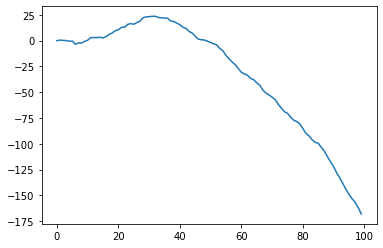

In [38]:
plt.plot(states_un[:100,:] @ C.T)